In [2]:
from py2neo import Graph, Node, Relationship

In [3]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random

In [4]:
def switch_database(database):
    host = "localhost"
    password = "0000"
    graph = Graph(host=host, password=password, name=database) 
    return graph    

In [5]:
graph = switch_database('neo4j')

In [6]:
# Retrieve user-id lookup table
query = "MATCH (n:User) RETURN n.name as User"
userID_df = graph.run(query).to_data_frame()

In [7]:
# Retrieve comedian-id lookup table
query = "MATCH (n:Comedian) RETURN n.name as Comedian"
comedianID_df = graph.run(query).to_data_frame()

In [8]:
query="""
MATCH (u:User)-[com1:commented_on]->(c:Comedian)<-[com2:commented_on]-(other:User)
//WHERE ID(u) < ID(other)
WITH u, other, COLLECT(com1.rating) as r1, COLLECT(com2.rating) as r2

MATCH (u)-[:commented_on]->(uc:Comedian)
WITH u,other, COLLECT(ID(uc)) AS s1, r1, r2
MATCH (other)-[:commented_on]->(oc:Comedian)
WITH u,other, s1, COLLECT(ID(oc)) AS s2, r1, r2

WITH u,other, gds.alpha.similarity.jaccard(s1,s2) as jaccard, gds.alpha.similarity.cosine(r1,r2) as cosine_sim
RETURN u.name AS User1, other.name AS User2, 1 - jaccard * cosine_sim AS weight
"""

user_distance_df = graph.run(query).to_data_frame()

In [9]:
query="""
//MATCH (c1:Comedian)-[:has_keyword]->()<-[:has_keyword]-(c2:Comedian)
//WHERE ID(c1) < ID(c2)

MATCH (c1)-[:has_keyword]->(k1:Keyword)
WITH c1, COLLECT(ID(k1)) AS s1
MATCH (c2)-[:has_keyword]->(k2:Keyword)
WITH c1, c2, COLLECT(ID(k2)) AS s2, s1

RETURN c1.name AS Comedian1, c2.name AS Comedian2, 1-gds.alpha.similarity.jaccard(s1,s2) as weight
"""

comedian_distance_df = graph.run(query).to_data_frame()

### FastMap

In [10]:
def new_distance(old_dist, xi, xj):
    return np.sqrt(old_dist**2 - (xi-xj)**2)


def law_of_cosine(ai, bi, ab):
    return (ai**2 + ab**2 - bi**2) / (2*ab)


def fastmap(words, data_matrix, dim=2):
    # the first column is all zeros to facilitate the calculation, and the return will omit the first column.
    points = np.zeros((len(words), dim+1))
    for d in range(dim):
        # Step 1: Find the farthest pair heuristically
        # -- Step 1.1: randomly choose a point along with its farthest counterpart.
        current_p = random.randint(0, len(words) - 1)
        previous_p = current_p
        farthest_p = np.argmax([new_distance(data_matrix[current_p, i], points[i, d], points[current_p, d]) for i in range(len(words))])
        # -- Step 1.2: Make farthest point the current point and find its farthest counterpart recursively,
        # until the two points are mutully farthest.
        while previous_p != farthest_p:
            previous_p = current_p
            current_p = farthest_p
            farthest_p = np.argmax([new_distance(data_matrix[current_p, i], points[i, d], points[current_p, d]) for i in range(len(words))])

        # Step 2: Make the farthest pair on the same axis, and use the law of cosine to determine the corrdinations
        # for other points
        d_ab = new_distance(data_matrix[current_p, farthest_p], points[current_p, d], points[farthest_p, d])
        for i in range(len(words)):
            if i == current_p:
                points[i, d+1] = 0
            if i == farthest_p:
                points[i, d+1] = d_ab
            else:
                d_ai = new_distance(data_matrix[current_p, i], points[current_p, d], points[i, d])
                d_bi = new_distance(data_matrix[i, farthest_p], points[i, d], points[farthest_p, d])
                xi = law_of_cosine(d_ai, d_bi, d_ab)
                points[i, d+1] = xi
    return np.array(points[:, 1:])

In [11]:
user_dict = dict(zip(userID_df['User'],userID_df.index))
comedian_dict = dict(zip(comedianID_df['Comedian'],comedianID_df.index))

In [12]:
# discard = ['russell peters','pete davidson','chris delia','ramy youssef']
# discard = ['tom segura','peal brennan','iliza shiesinger','sebastian maniscalco']
# discard = ['bassan minhj','jimmy o yang','patton oswalt','aziz ansari']
# comedian_distance_df = comedian_distance_df[~comedian_distance_df['Comedian1'].isin(discard)]
# comedian_distance_df = comedian_distance_df[~comedian_distance_df['Comedian2'].isin(discard)]

In [13]:
comedian_distance_df['C1'] = comedian_distance_df['Comedian1'].apply(lambda x: comedian_dict[x])
comedian_distance_df['C2'] = comedian_distance_df['Comedian2'].apply(lambda x: comedian_dict[x])
comedian_distance_df.head()

,Comedian1,Comedian2,weight,C1,C2
0,hannah gadsby,hannah gadsby,0.000000,30,30
1,hannah gadsby,patton oswalt,0.965812,30,35
2,hannah gadsby,neal brennan,0.993289,30,37
3,hannah gadsby,jim jefferies,0.968872,30,15
4,hannah gadsby,iliza shlesinger,0.973502,30,20


In [14]:
com_distance_matrix = comedian_distance_df.pivot_table(index=['C1'], columns=['C2'],values=['weight'])
rename_columns = [c[1] for c in com_distance_matrix.columns]
com_distance_matrix.columns = rename_columns
com_distance_matrix

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
C1,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.990698,0.980456,0.989247,0.978769,0.995595,0.984925,1.000000,0.976623,0.977839,...,0.981481,0.995392,0.987755,0.985112,0.985088,0.984211,1.000000,0.988506,0.992218,0.989390
1,0.990698,0.000000,1.000000,0.993590,0.988636,0.990196,1.000000,1.000000,0.996269,1.000000,...,0.987138,1.000000,1.000000,0.989324,0.996109,0.992278,1.000000,0.995575,1.000000,1.000000
2,0.980456,1.000000,0.000000,0.988000,0.995556,0.994949,0.983740,0.995192,0.974719,0.988095,...,0.992647,1.000000,0.990783,0.989362,0.988341,0.994366,0.983784,0.987461,0.995633,0.991404
3,0.989247,0.993590,0.988000,0.000000,0.985542,1.000000,0.991202,1.000000,0.969136,0.996753,...,0.992042,0.993631,0.989247,0.988406,0.991728,0.971609,0.993590,0.986111,1.000000,0.974441
4,0.978769,0.988636,0.995556,0.985542,0.000000,0.986188,0.969639,0.989276,0.971042,0.992063,...,0.982425,0.997191,1.000000,0.981413,0.989080,0.964497,0.997183,0.977083,1.000000,0.980392
5,0.995595,0.990196,0.994949,1.000000,0.986188,0.000000,0.989547,1.000000,0.981818,0.992095,...,0.996923,0.990291,1.000000,0.989726,0.994214,0.996310,0.980198,0.991525,1.000000,0.992453
6,0.984925,1.000000,0.983740,0.991202,0.969639,0.989547,0.000000,0.986486,0.977578,0.983491,...,0.969199,0.996416,0.993506,0.978308,0.984167,0.986425,0.996403,0.977778,0.987382,0.986270
7,1.000000,1.000000,0.995192,1.000000,0.989276,1.000000,0.986486,0.000000,0.996540,0.992395,...,0.990991,1.000000,1.000000,1.000000,0.993308,0.985612,1.000000,0.979424,0.993506,1.000000
8,0.976623,0.996269,0.974719,0.969136,0.971042,0.981818,0.977578,0.996540,0.000000,0.973171,...,0.985567,0.996283,0.986486,0.977827,0.978885,0.971831,0.996269,0.979798,0.990260,0.971496


In [15]:
comedians = comedian_distance_df.Comedian1.unique()
result = fastmap(comedians, com_distance_matrix.to_numpy())

In [16]:
def plot_fastmap(fastmap_result, labels):
    """
    Plots the words on a 2D plane using FastMap solution.
    """
    fig = plt.figure(figsize=(10,10))
    # Plot the points
    plt.scatter(fastmap_result[:, 0], fastmap_result[:, 1])
#     plt.xlim([0.45, 0.55])
#     plt.ylim([0.45, 0.55])
    # annotation
#     for p in range(len(labels)):
#         plt.text(fastmap_result[p, 0], fastmap_result[p, 1], labels[p])
    plt.plot()

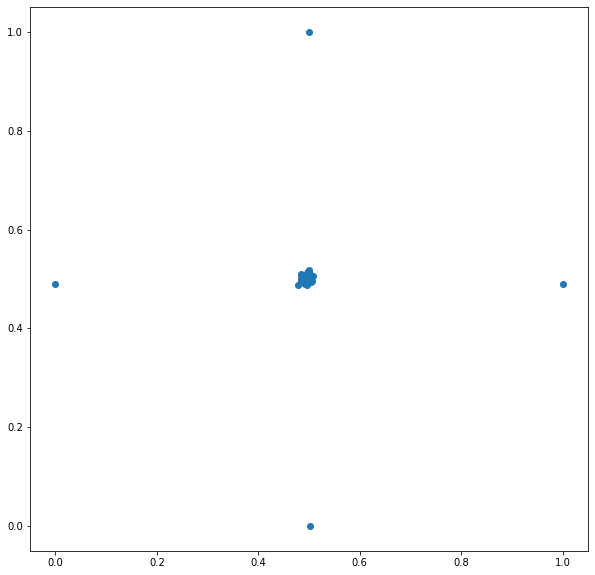

In [17]:
plot_fastmap(result, comedians)

In [18]:
user_distance_df['U1'] = user_distance_df['User1'].apply(lambda x: user_dict[x])
user_distance_df['U2'] = user_distance_df['User2'].apply(lambda x: user_dict[x])
user_distance_df.head()

,User1,User2,weight,U1,U2
0,goldplatinumx,liqu1d16,0.833333,445,411
1,sampson tendai mutsago,liqu1d16,0.916667,684,411
2,saravanesh raja,liqu1d16,0.923077,42,411
3,miles boehmer,liqu1d16,0.877565,345,411
4,itsyagirll,liqu1d16,0.821070,506,411


In [19]:
user_distance_matrix = user_distance_df.pivot_table(index=['U1'], columns=['U2'],values=['weight'])
rename_columns = [c[1] for c in user_distance_matrix.columns]
user_distance_matrix.columns = rename_columns
user_distance_matrix = user_distance_matrix.fillna(1) - np.eye(len(user_distance_matrix))
user_distance_matrix

,0,1,2,3,4,5,6,7,8,9,...,1059,1060,1061,1062,1063,1064,1065,1066,1067,1068
U1,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.858170,0.866893,0.837823,0.941176,0.874235,1.000000,0.824063,0.937500,0.804482,...,0.923077,0.928571,0.933333,0.907433,0.876384,0.933333,0.933333,0.846500,0.880239,0.937500
1,0.858170,0.000000,0.591065,0.862818,0.868561,0.820214,0.909091,0.672594,0.833562,0.831994,...,0.888889,0.900000,0.551762,0.916667,0.729760,0.800447,0.676202,0.637946,0.667173,0.827462
2,0.866893,0.591065,0.000000,0.792933,0.751106,0.923077,0.832945,0.713580,0.836148,0.683514,...,0.900000,0.803043,0.614314,0.742819,0.764305,0.826145,0.819454,0.672122,0.806031,0.834018
3,0.837823,0.862818,0.792933,0.000000,0.805081,0.937500,0.866496,0.774675,0.702297,0.800170,...,0.923077,0.928571,0.783681,0.866731,0.823770,0.791812,0.679175,0.750803,0.753822,0.866763
4,0.941176,0.868561,0.751106,0.805081,0.000000,1.000000,0.923077,0.747483,0.852073,0.851208,...,0.801878,0.862038,0.847266,0.928571,0.887150,0.864690,0.923077,0.916667,0.825392,0.851721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1064,0.933333,0.800447,0.826145,0.791812,0.864690,0.820984,0.909091,0.778273,0.721886,0.836293,...,0.888889,0.781613,0.852677,0.916667,0.728304,0.000000,0.800343,0.688760,0.809773,0.831678
1065,0.933333,0.676202,0.819454,0.679175,0.923077,0.916667,0.816377,0.777308,0.704575,0.837195,...,1.000000,0.900000,0.691071,0.916667,0.743324,0.800343,0.000000,0.900000,0.900000,0.916667
1066,0.846500,0.637946,0.672122,0.750803,0.916667,0.804855,0.900000,0.754581,0.802562,0.821658,...,0.875000,0.888889,0.797261,0.801860,0.766274,0.688760,0.900000,0.000000,0.581899,0.800447


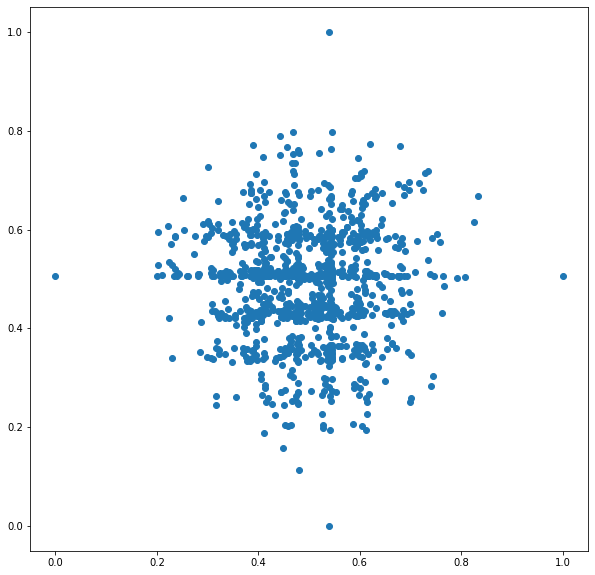

In [20]:
users = user_distance_df.User1.unique()
result = fastmap(users, user_distance_matrix.to_numpy())
plot_fastmap(result, users)

### KNN

In [21]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [22]:
def knn(data, k=4):
    model = KMeans(n_clusters=k)
    model.fit(data)
    groups = model.labels_  
    color = ['blue', 'green', 'cyan', 'red', 'purple','black']
    fig = plt.figure(figsize=(7, 7))
    for i, g in enumerate(groups):
        plt.scatter(data[i, 0],data[i,1],color=color[g])
    plt.show()
    return model

In [23]:
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(result)
    sse.append(kmeans.inertia_)

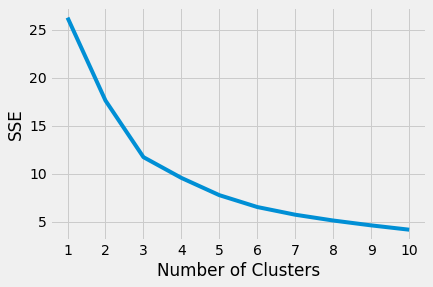

In [24]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse) 
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [25]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(result)
    score = silhouette_score(result, kmeans.labels_)
    silhouette_coefficients.append(score)

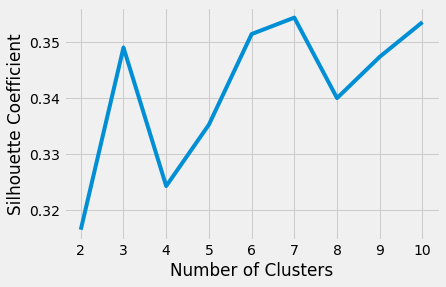

In [26]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

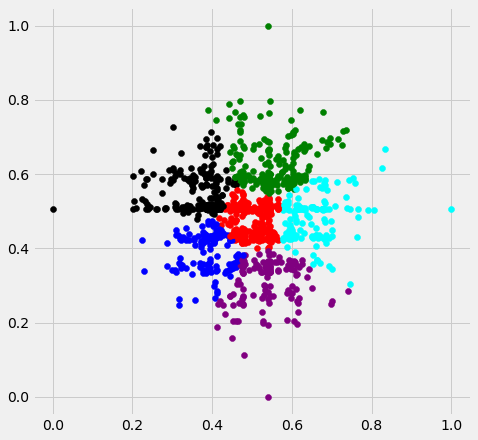

In [27]:
knn_model = knn(result, 6)

In [28]:
user_group = pd.DataFrame(knn_model.labels_, columns=['Group'])
user_group['User'] = userID_df['User']
user_group.tail()

,Group,User
1064,0,babygirl maya
1065,0,kuku khan
1066,3,glenn davey
1067,3,racer z
1068,5,john walls


In [30]:
user_group.to_pickle('user_group.pkl')

### Prepare data

In [201]:
import re
import string

In [202]:
def normalize_text(text):
    # Lowercase every words
    text = text.lower()
    # Get rid of the punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # Get rid of these specific punctuations
    text = re.sub('[‘’“”…]', '', text)
    # Get rid of '\n'
    text = re.sub('\n', '', text)
    return text

In [276]:
# Training set
X_train_df = pd.read_pickle('X_train.pkl')
Y_train_df = pd.read_pickle('Y_train.pkl')
train_df = pd.concat([X_train_df, Y_train_df], axis=1)
train_df.Name = train_df.Name.apply(normalize_text)
train_df.Comedian = train_df.Comedian.apply(normalize_text)
train_df.head()

,Name,Comedian,Rating
0,respekt,marc maron,0.250000
1,mais abdullatif,ramy youssef,0.600000
2,benito ramirez,roy wood jr,0.541667
3,quarantinewhile,jo koy,0.633333
4,its me,tom segura,0.700000


In [277]:
# Test set
X_test_df = pd.read_pickle('X_test.pkl')
Y_test_df = pd.read_pickle('Y_test.pkl')
test_df = pd.concat([X_test_df, Y_test_df], axis=1)
test_df.Name = test_df.Name.apply(normalize_text)
test_df.Comedian = test_df.Comedian.apply(normalize_text)
test_df.head()

,Name,Comedian,Rating
0,nik d,kenny sebastian,1.000000
1,mr 79,chris rock,0.571667
2,satish rengarajan,joe rogan,0.400000
3,maliah h,iliza shlesinger,0.450000
4,goliath3719,whitney cummings,0.066667


#### Comedian Properties

In [205]:
# Comedian Properties
cp_df = pd.read_excel('ComedianProperties.xlsx')
# Categorize the year of birth of the comedians
cp_df['year group'] = cp_df.year.apply(lambda x: str(x)[:3]+'0s')
# Remove unnecessary columns
cp_df = cp_df.drop(['spouseLabel','children_number','birthdate','year'], axis=1)
# change column names
cp_df.columns = ['Comedian','Citizenship','Ethnicity','Married','Gender','Year']
# Numerize Married Column
cp_df.Married = cp_df.Married.apply(lambda x: str(x))
# Normalize comedian names
cp_df.Comedian = cp_df['Comedian'].apply(normalize_text)
# Set index to comedian
cp_df = cp_df.set_index(cp_df['Comedian'])
# Drop Comedian Column
cp_df = cp_df.drop('Comedian', axis=1)
cp_df.head()

,Citizenship,Ethnicity,Married,Gender,Year
Comedian,,,,,
andy woodhull,United States of America,White,True,male,1980s
ramy youssef,United States of America,Egyptian-American Muslim,False,male,1990s
amy schumer,United States of America,American Jews,True,female,1980s
arsenio hall,United States of America,African Americans,False,male,1950s
aziz ansari,United States of America,Tamil American,False,male,1980s


In [253]:
# First extract all kinds of ethnicity
ethnicities = dict()
for e_list in cp_df.Ethnicity.unique():
    for e in e_list.split(','):
        if e.strip() not in ethnicities:
            ethnicities[e.strip()] = len(ethnicities.keys())
        
# Assgin a encoding to each comedian
def encode_ethnicity(text):
    encode = [0 for i in range(len(ethnicities))]
    for e in text.split(','):
        if e.strip() in ethnicities:
            encode[ethnicities[e.strip()]] = 1
    return encode
print(ethnicities)
ethnicity_df = cp_df['Ethnicity'].apply(encode_ethnicity)
ethnicity_df = ethnicity_df.apply(pd.Series)
ethnicity_df.columns = [f"Ethnicity_{c}" for c in ethnicity_df.columns]
ethnicity_df.head()

{'White': 0, 'Egyptian-American Muslim': 1, 'American Jews': 2, 'African Americans': 3, 'Tamil American': 4, 'Irish': 5, 'German': 6, 'Italian': 7, 'Polish': 8, 'Mestizo Mexican': 9, 'Australian': 10, 'Indian American': 11, 'Ashkenazi Jewish': 12, 'English': 13, 'Filipino': 14, 'European-American': 15, 'Chinese': 16, 'Indian': 17, 'Scottish': 18, 'Hungarian': 19, 'Malaysian': 20, 'Canadian': 21, 'French': 22, 'Spanish': 23, 'Peruvian': 24, 'Swiss-German': 25, 'South African': 26, 'New Zealand': 27}


,Ethnicity_0,Ethnicity_1,Ethnicity_2,Ethnicity_3,Ethnicity_4,Ethnicity_5,Ethnicity_6,Ethnicity_7,Ethnicity_8,Ethnicity_9,...,Ethnicity_18,Ethnicity_19,Ethnicity_20,Ethnicity_21,Ethnicity_22,Ethnicity_23,Ethnicity_24,Ethnicity_25,Ethnicity_26,Ethnicity_27
Comedian,,,,,,,,,,,,,,,,,,,,,
andy woodhull,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ramy youssef,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
amy schumer,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
arsenio hall,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aziz ansari,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [207]:
cp_df2 = cp_df.drop('Ethnicity', axis=1)
cp_dummy = pd.get_dummies(cp_df2, drop_first=True)
# Append ethnicity back 
cp_dummy = pd.concat([cp_dummy, ethnicity_df], axis=1)
cp_dummy = cp_dummy.reset_index()
cp_dummy.head()

,Citizenship_Canada,Citizenship_India,Citizenship_New Zealand,Citizenship_People's Republic of China,Citizenship_Philippines,Citizenship_South Africa,Citizenship_United Kingdom,Citizenship_United States of America,Married_True,Gender_male,...,Ethnicity_18,Ethnicity_19,Ethnicity_20,Ethnicity_21,Ethnicity_22,Ethnicity_23,Ethnicity_24,Ethnicity_25,Ethnicity_26,Ethnicity_27
Comedian,,,,,,,,,,,,,,,,,,,,,
andy woodhull,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
ramy youssef,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
amy schumer,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
arsenio hall,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
aziz ansari,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [230]:
def build_dataset(df, com_property, user_group):
    y = df['Rating']
    df = df.drop('Rating', axis=1)
    df = df.merge(user_group, left_on='Name',right_on='User')
    df = df.merge(com_property, on='Comedian')
    df = df.drop(['Name', 'Comedian', 'User'], axis=1)
    return df, y

In [278]:
x_train, y_train = build_dataset(train_df, cp_dummy, user_group)
y_train = y_train.apply(lambda x: 1 if x>= 0.5 else 0)

In [308]:
x_test, y_test = build_dataset(test_df, cp_dummy, user_group)
y_test = y_test.apply(lambda x: 1 if x>= 0.5 else 0)

### Feature importance

In [233]:
from sklearn.ensemble import RandomForestRegressor

In [234]:
rf = RandomForestRegressor(max_features=13, n_estimators=500, random_state=1)
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=13, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=1, verbose=0,
                      warm_start=False)

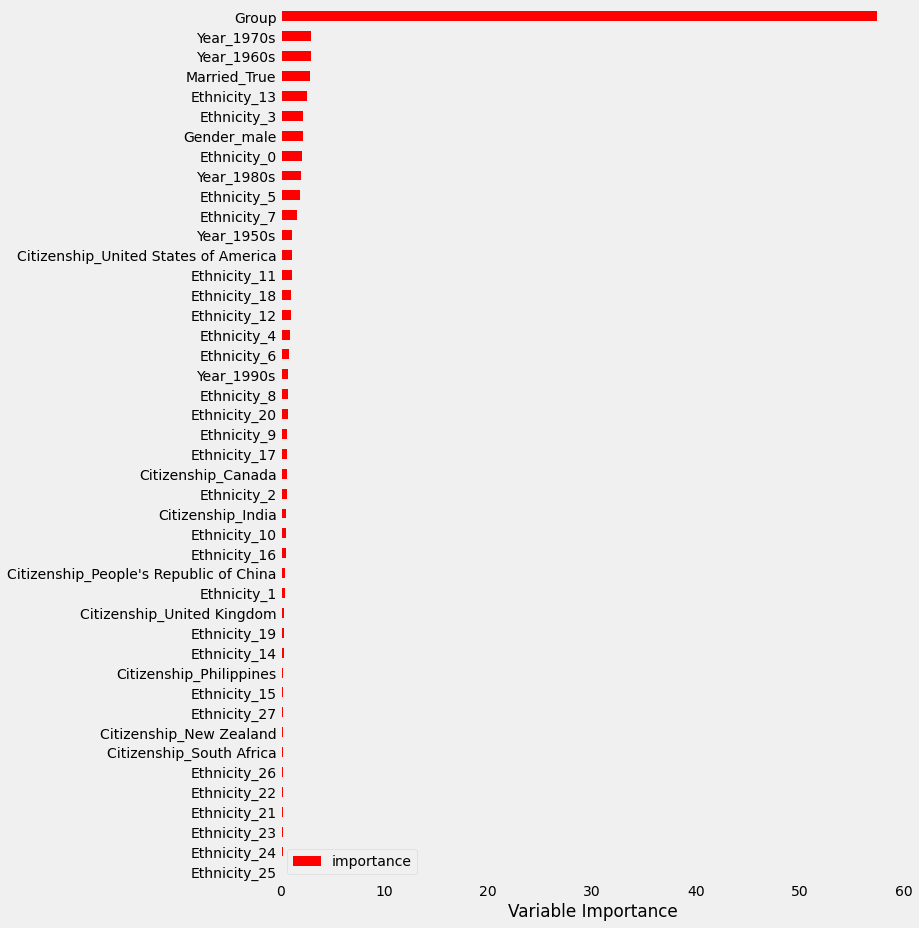

In [318]:
importance = pd.DataFrame({'importance' : rf.feature_importances_ * 100},
                         index = x_train.columns)
fig= plt.figure(figsize=(10,15))
important_features = importance.sort_values(by='importance',axis = 0, ascending = True)
important_features.plot(ax=plt.gca(),kind='barh',color='r')
plt.xlabel('Variable Importance')
plt.grid()

### Cross validation

In [284]:
import warnings
warnings.filterwarnings("ignore")

In [256]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [255]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [257]:
models = []
models.append(('RD', DummyClassifier(strategy='uniform')))
models.append(('LR',make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear'))))
models.append(('LDA',LinearDiscriminantAnalysis()))
models.append(('KNN',KNeighborsClassifier()))
models.append(('DT',DecisionTreeClassifier()))
models.append(('RF',RandomForestClassifier()))
models.append(('NB',GaussianNB()))
models.append(('SVM',make_pipeline(StandardScaler(), SVC(kernel='rbf', gamma='auto'))))
models.append(('XGB',make_pipeline(StandardScaler(), XGBClassifier())))

In [288]:
names = []
results = []
means = []
sdevs = []
scoring = 'accuracy'

In [289]:
for name,model in models:
    cv_method = StratifiedKFold(n_splits = 20)
    cv_results = cross_val_score(model,x_train,y_train,cv=cv_method,scoring=scoring)
    results.append(cv_results)
    means.append(cv_results.mean())
    sdevs.append(cv_results.std())
    names.append(name)
    print(f"{name} done.")

RD done.
LR done.
LDA done.
KNN done.
DT done.
RF done.
NB done.
SVM done.
XGB done.


In [290]:
df1 = pd.DataFrame()
df1['name'] = names
df1[f'mean {scoring}'] = means
df1[f'{scoring} std dev'] = sdevs
df1

,name,mean accuracy,accuracy std dev
0,RD,0.498281,0.023185
1,LR,0.611981,0.137623
2,LDA,0.610185,0.136999
3,KNN,0.557398,0.104303
4,DT,0.599990,0.125454
5,RF,0.612795,0.127536
6,NB,0.562494,0.152517
7,SVM,0.626721,0.128574
8,XGB,0.626307,0.128371


Text(0, 0.5, 'Test accuracy Rate')

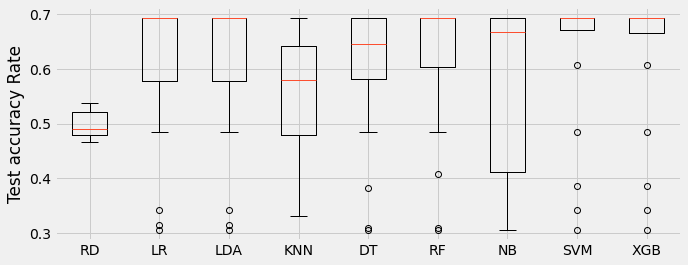

In [291]:
plt.figure(figsize=(10,4))
plt.boxplot(results)
plt.xticks(range(1,10),names)
plt.ylabel(f'Test {scoring} Rate')

#### svm

In [323]:
select = list(important_features[important_features.importance > 2].index)

In [326]:
train_x = x_train[select]
test_x = x_test[select]

In [329]:
pre = []

for c in range(1,21):
    svc = SVC(kernel='rbf', C=c, gamma='auto')
    result = svc.fit(train_x, y_train)
    pre.append(result.score(train_x, y_train))

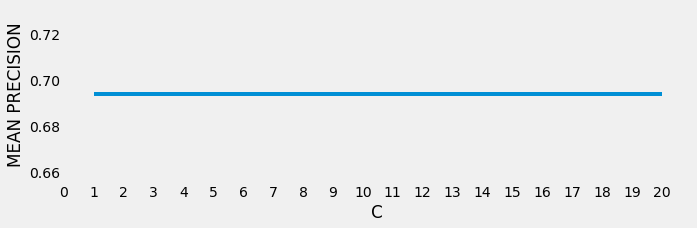

In [330]:
fig = plt.figure(figsize=(10,3))
plt.plot([x for x in range(1, 21)], pre)
x_range = range(0,21)
y_range = range(0,21)
plt.xlabel('C')
plt.ylabel('MEAN PRECISION')
plt.xticks(x_range, y_range)
plt.grid()

In [ ]:
svc = SVC(kernel='poly', gamma='auto', coef0=100 )
result = svc.fit(train_x, y_train)
result.score(test_x, y_test)

In [ ]:
y_pred = result.predict(test_x)
pd.DataFrame(confusion_matrix(y_test, y_pred), index= [-1, 1], columns=[-1, 1])